# CANN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

## Model

In [3]:
class CANN1D(bp.NeuGroup):
  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D, self).__init__(size=num, **kwargs)

    # parameters
    self.tau = tau  # The synaptic time constant
    self.k = k  # Degree of the rescaled inhibition
    self.a = a  # Half-width of the range of excitatory connections
    self.A = A  # Magnitude of the external input
    self.J0 = J0  # maximum connection value

    # feature space
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)  # The encoded feature values
    self.rho = num / self.z_range  # The neural density
    self.dx = self.z_range / num  # The stimulus density

    # variables
    self.u = bm.Variable(bm.zeros(num))
    self.input = bm.Variable(bm.zeros(num))

    # The connection matrix
    self.conn_mat = self.make_conn(self.x)

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, u, t, Iext):
    r1 = bm.square(u)
    r2 = 1.0 + self.k * bm.sum(r1)
    r = r1 / r2
    Irec = bm.dot(self.conn_mat, r)
    du = (-u + Irec + Iext) / self.tau
    return du

  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  def make_conn(self, x):
    assert bm.ndim(x) == 1
    x_left = bm.reshape(x, (-1, 1))
    x_right = bm.repeat(x.reshape((1, -1)), len(x), axis=0)
    d = self.dist(x_left - x_right)
    Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
    return Jxx

  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, _t, _dt):
    self.u[:] = self.integral(self.u, _t, self.input)
    self.input[:] = 0.

  def cell(self, u):
    return self.derivative(u, 0., 0.)

## Helper functions

In [13]:
def find_fixed_points(cann, do_pca=False, do_animation=False, tolerance=1e-8):
  candidates = cann.get_stimulus_by_pos(bm.arange(-bm.pi, bm.pi, 0.005).reshape((-1, 1)))

  finder = bp.analysis.FixedPointFinder(candidates=candidates, f_cell=cann.cell, noise=0.5)
  finder.find_fps_with_gd_method(
    tolerance=1e-6, num_batch=200,
    opt_setting=dict(method=bm.optimizers.Adam,
                     lr=bm.optimizers.ExponentialDecay(0.1, 2, 0.999)),
  )
  finder.filter_loss(tolerance)
  finder.keep_unique()
  finder.exclude_outliers()

  print('Losses of fixed points:')
  print(finder.losses)

  if do_pca:
    pca = PCA(2)
    fp_pcs = pca.fit_transform(finder.fixed_points)
    plt.plot(fp_pcs[:, 0], fp_pcs[:, 1], 'x', label='fixed points')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('Fixed points PCA')
    plt.legend()
    plt.show()

  if do_animation:
    bp.visualize.animate_1D(
      dynamical_vars={'ys': finder.fixed_points, 'xs': cann.x, 'legend': 'fixed point'},
      frame_step=1, frame_delay=100, show=True,
    )

  return finder.fixed_points

In [7]:
def verify_fp_through_simulation(cann, fixed_points, num=3):
  for i in range(num):
    cann.u[:] = fixed_points[i]
    runner = bp.StructRunner(cann, monitors=['u'], dyn_vars=cann.vars())
    runner(100.)
    plt.plot(runner.mon.ts, runner.mon.u.max(axis=1))
    plt.ylim(0, runner.mon.u.max() + 1)
    plt.show()

In [8]:
def verify_fixed_point_stability(cann, fixed_points, num=3):
  finder = bp.analysis.FixedPointFinder(candidates=bm.random.rand(10),
                                        f_cell=cann.cell, noise=0.0)
  J = finder.compute_jacobians(fixed_points[:num])

  for i in range(num):
    eigval, eigvec = np.linalg.eig(np.asarray(J[i]))
    plt.figure()
    plt.scatter(np.real(eigval), np.imag(eigval))
    plt.plot([0, 0], [-1, 1], '--')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()

In [9]:
def visualize_fixed_points(fps, plot_ids=(0,), xs=None):
  for i in plot_ids:
    if xs is None:
      plt.plot(fps[i], label=f'FP-{i}')
    else:
      plt.plot(xs, fps[i], label=f'FP-{i}')
  plt.legend()
  plt.show()

## Find fixed points

In [7]:
model = CANN1D(num=512, k=0.1, A=30, a=0.5)

Adding noise to fixed point candidates.
Optimizing to find fixed points:
    Batches 1-200 in 2.37 sec, Training loss 0.0071144686
    Batches 201-400 in 2.21 sec, Training loss 0.0002719477
    Batches 401-600 in 2.13 sec, Training loss 0.0002630050
    Batches 601-800 in 2.41 sec, Training loss 0.0002625508
    Batches 801-1000 in 2.24 sec, Training loss 0.0002620590
    Batches 1001-1200 in 2.09 sec, Training loss 0.0002615382
    Batches 1201-1400 in 2.21 sec, Training loss 0.0002609951
    Batches 1401-1600 in 2.21 sec, Training loss 0.0002604347
    Batches 1601-1800 in 2.20 sec, Training loss 0.0002598611
    Batches 1801-2000 in 2.12 sec, Training loss 0.0002592763
    Batches 2001-2200 in 2.27 sec, Training loss 0.0002586833
    Batches 2201-2400 in 2.31 sec, Training loss 0.0002580842
    Batches 2401-2600 in 2.21 sec, Training loss 0.0002574802
    Batches 2601-2800 in 2.14 sec, Training loss 0.0002568729
    Batches 2801-3000 in 2.32 sec, Training loss 0.0002562624
    Batc

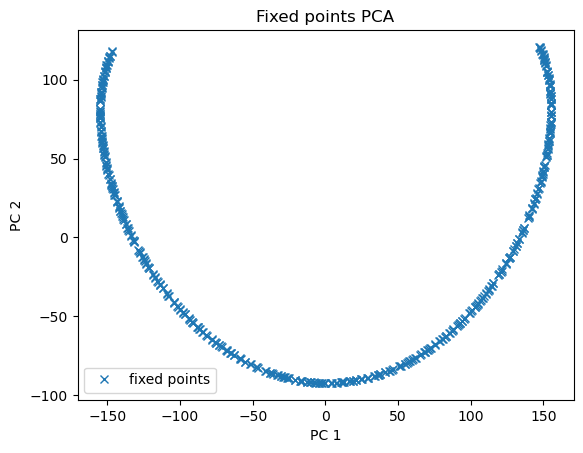

In [8]:
fps = find_fixed_points(model, do_pca=True, do_animation=False)

In [9]:
# verify_fp_through_simulation(model, fps)

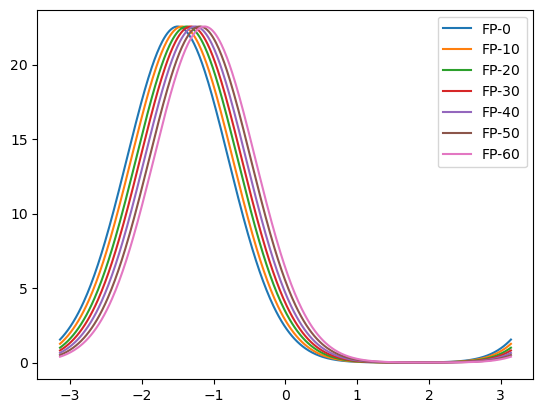

In [12]:
visualize_fixed_points(fps, plot_ids=(0, 10, 20, 30, 40, 50, 60), xs=model.x)

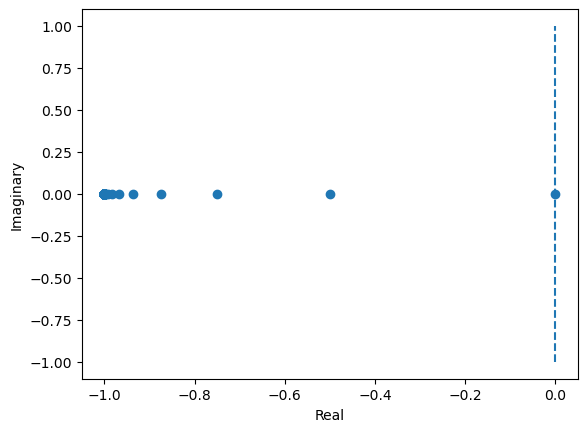

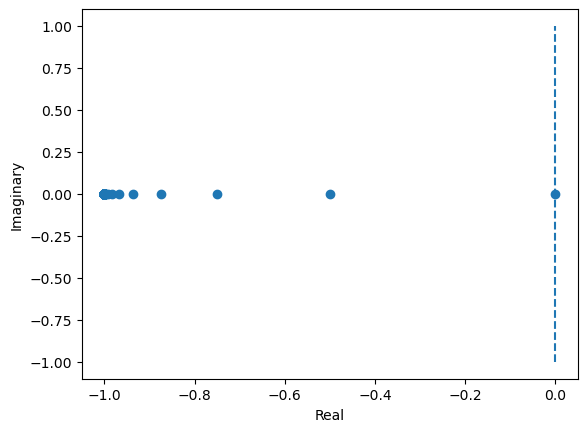

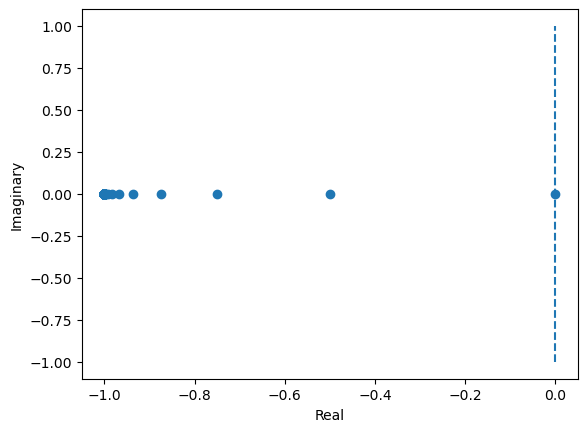

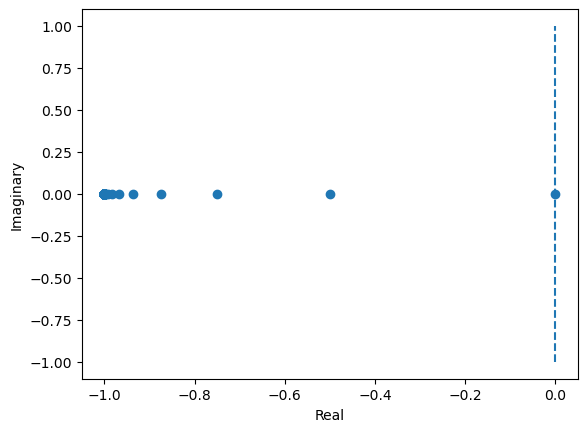

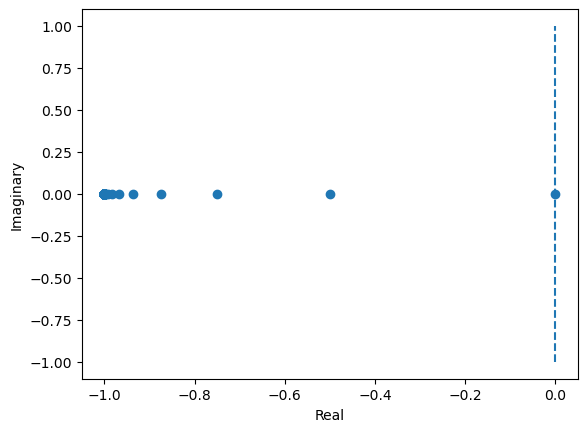

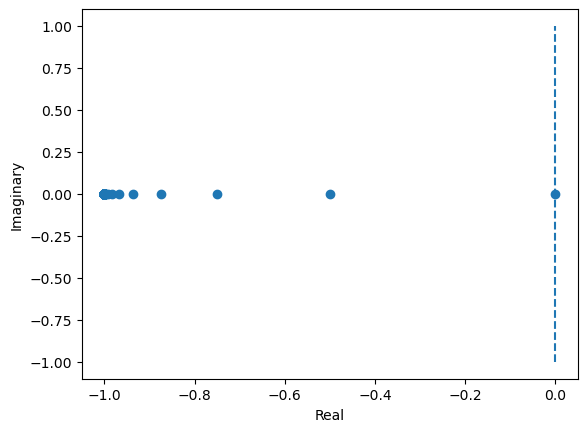

In [10]:
verify_fixed_point_stability(model, fps, num=6)

## Results 2

In [11]:
model2 = CANN1D(num=512, k=0.1, A=10, a=0.5)

Adding noise to fixed point candidates.
Optimizing to find fixed points:
    Batches 1-200 in 2.16 sec, Training loss 0.7176399231
    Batches 201-400 in 2.11 sec, Training loss 0.3062165678
    Batches 401-600 in 2.07 sec, Training loss 0.0989254564
    Batches 601-800 in 2.06 sec, Training loss 0.0346553139
    Batches 801-1000 in 2.10 sec, Training loss 0.0155616524
    Batches 1001-1200 in 2.07 sec, Training loss 0.0084601650
    Batches 1201-1400 in 2.06 sec, Training loss 0.0051749004
    Batches 1401-1600 in 2.12 sec, Training loss 0.0034011304
    Batches 1601-1800 in 2.08 sec, Training loss 0.0023409908
    Batches 1801-2000 in 2.07 sec, Training loss 0.0016631879
    Batches 2001-2200 in 2.07 sec, Training loss 0.0012094951
    Batches 2201-2400 in 2.09 sec, Training loss 0.0008959539
    Batches 2401-2600 in 2.08 sec, Training loss 0.0006742902
    Batches 2601-2800 in 2.06 sec, Training loss 0.0005149881
    Batches 2801-3000 in 2.06 sec, Training loss 0.0003991152
    Batc

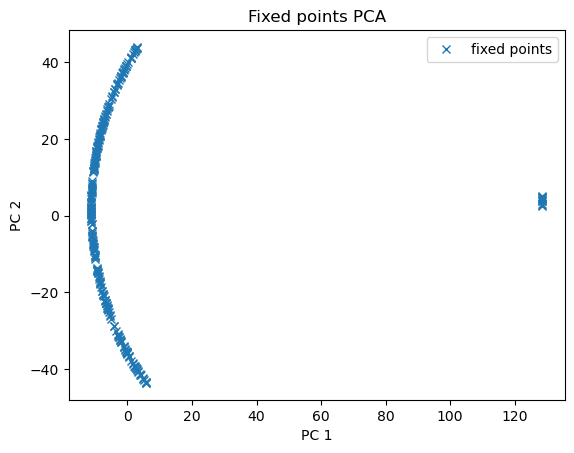

In [14]:
fps2 = find_fixed_points(model2, do_pca=True, do_animation=False, tolerance=1e-6)

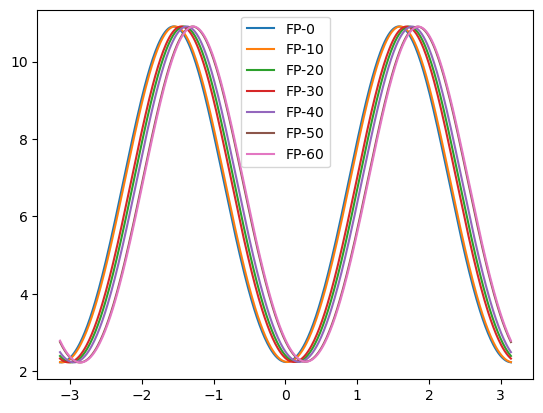

In [16]:
visualize_fixed_points(fps2, plot_ids=(0, 10, 20, 30, 40, 50, 60), xs=model2.x)

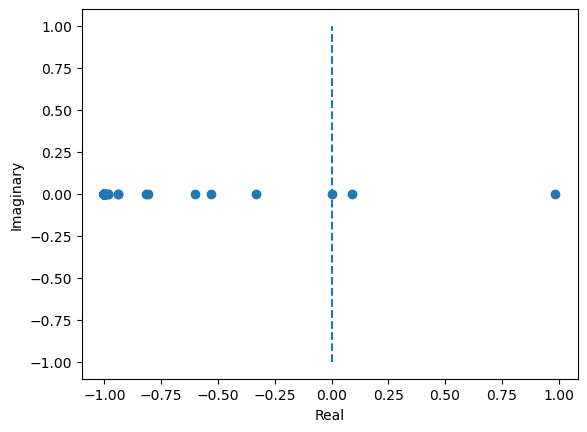

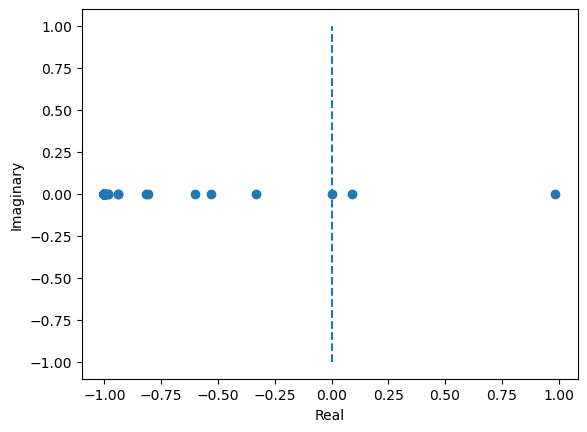

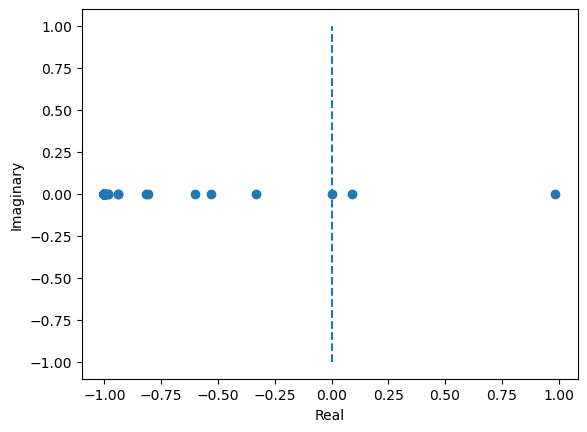

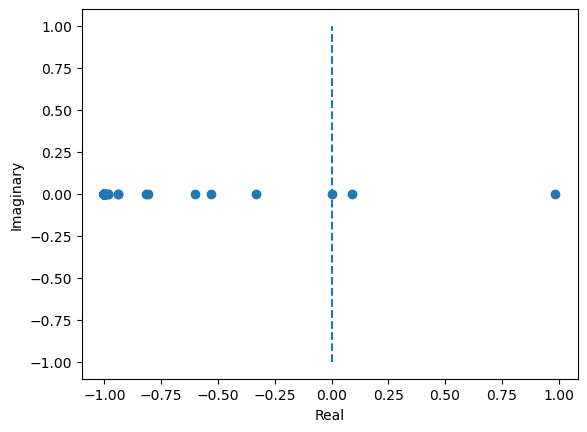

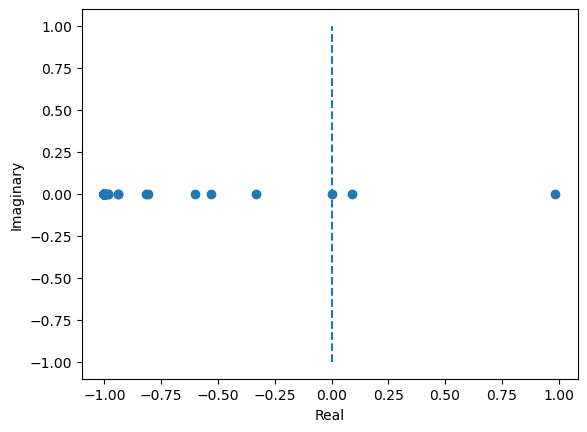

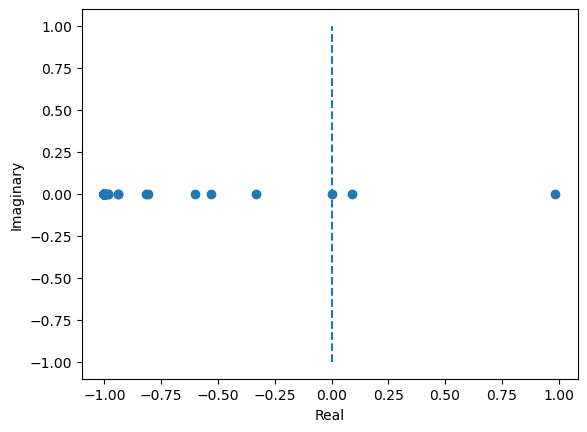

In [17]:
verify_fixed_point_stability(model2, fps2, num=6)

## Results 3

In [20]:
model3 = CANN1D(num=512, k=0.1, A=10, a=1.)

Adding noise to fixed point candidates.
Optimizing to find fixed points:
    Batches 1-200 in 2.18 sec, Training loss 0.0000636004
    Batches 201-400 in 2.12 sec, Training loss 0.0000633983
    Batches 401-600 in 2.20 sec, Training loss 0.0000631502
    Batches 601-800 in 2.15 sec, Training loss 0.0000628709
    Batches 801-1000 in 2.16 sec, Training loss 0.0000625693
    Batches 1001-1200 in 2.18 sec, Training loss 0.0000622517
    Batches 1201-1400 in 2.17 sec, Training loss 0.0000619225
    Batches 1401-1600 in 2.21 sec, Training loss 0.0000615851
    Batches 1601-1800 in 2.39 sec, Training loss 0.0000612422
    Batches 1801-2000 in 2.10 sec, Training loss 0.0000608961
    Batches 2001-2200 in 2.10 sec, Training loss 0.0000605482
    Batches 2201-2400 in 2.14 sec, Training loss 0.0000602005
    Batches 2401-2600 in 2.10 sec, Training loss 0.0000598538
    Batches 2601-2800 in 2.16 sec, Training loss 0.0000595094
    Batches 2801-3000 in 2.16 sec, Training loss 0.0000591684
    Batc

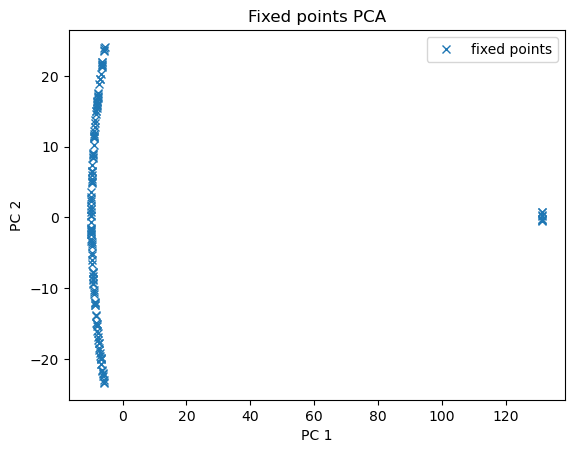

In [21]:
fps3 = find_fixed_points(model3, do_pca=True, do_animation=False, tolerance=1e-7)

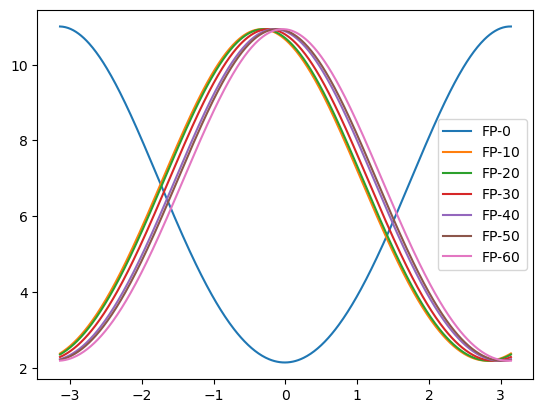

In [22]:
visualize_fixed_points(fps3, plot_ids=(0, 10, 20, 30, 40, 50, 60), xs=model3.x)

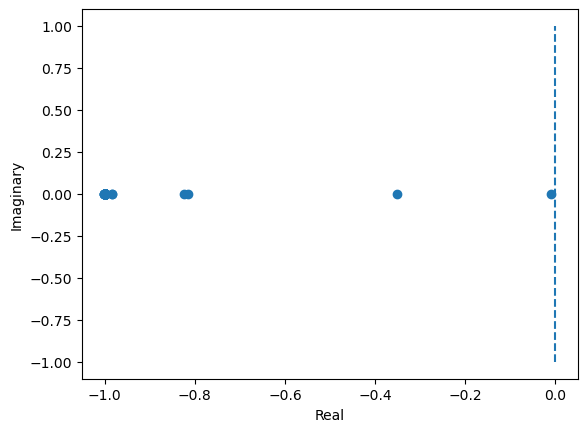

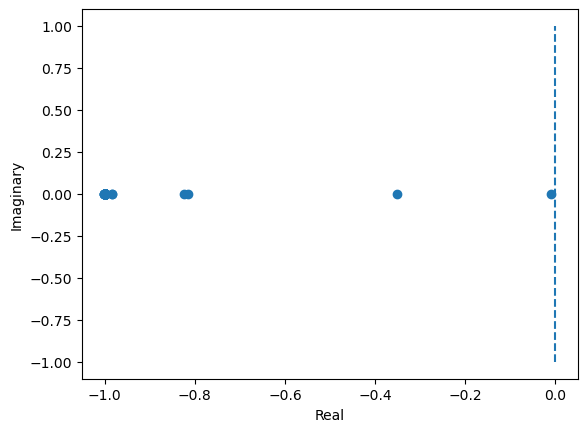

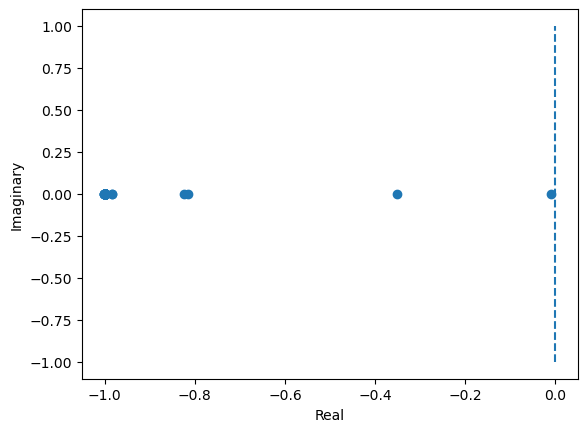

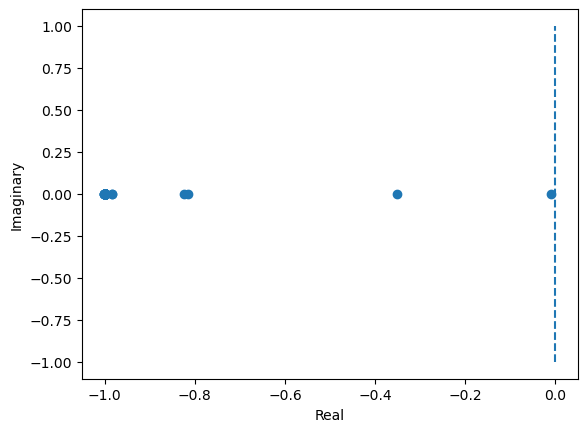

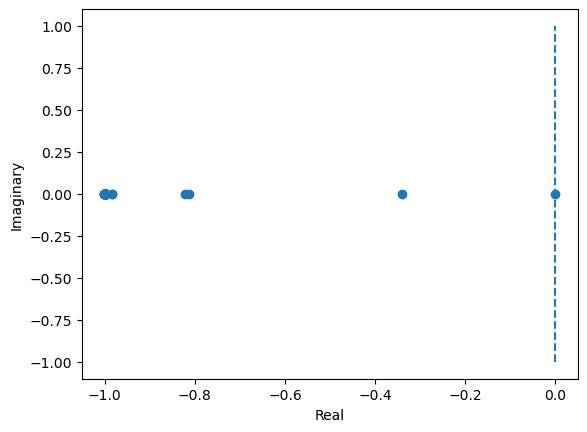

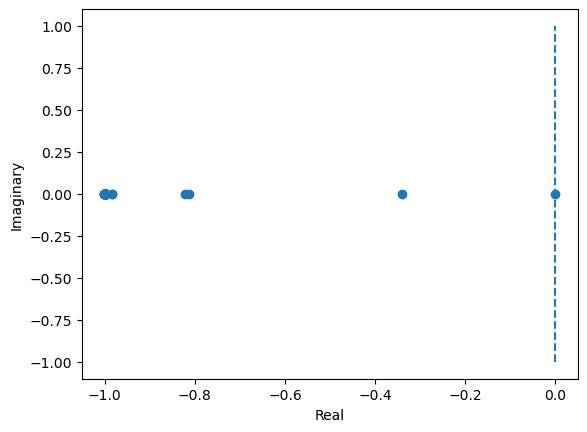

In [23]:
verify_fixed_point_stability(model3, fps3, num=6)